In [83]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import pandas as pd
import mne
from scipy.fftpack import fft

import tensorflow as tf
from sklearn.model_selection import KFold

In [2]:
# 32.704s is when the recording starts, it takes eeg12['time'].iloc[0]s for the eeg to show up(which would be changed to 0.00s)
# 34.951s is when the first trial starts. So first_trial_start_time is the start time of the first trial in the eeg12 dataframe
# Note: this should only be run once or first_trial_start_time wouldn't be correct
first_trial_start_time = 34.951 - 32.704 - eeg_sig['time'].iloc[0]
eeg_sig['time'] = eeg_sig['time'] - eeg_sig['time'].iloc[0]

NameError: name 'eeg_sig' is not defined

In [ ]:
first_trial_start_time

In [ ]:
eeg_sig.head()

In [ ]:
eeg_sig = eeg_sig.loc[eeg_sig['time'] > first_trial_start_time]

In [ ]:
eeg12 = eeg12.drop(columns=eeg12.keys()[-1])
eeg12['time'] = eeg12['time'] - eeg12['time'].iloc[0]

In [ ]:
eeg12

In [ ]:
eeg12 = eeg12.loc[eeg12['time']<129.999]

In [ ]:
# every 1500 samples is a trial (5s at 300Hz)
eeg12.iloc[:1500]

In [ ]:
# MNE doesn't work with pandas dataframe so it should be converted into np array
time_array = eeg12['time']
eeg12 = eeg12.to_numpy()[:,1:].T # drop out the time (7,39000)
eeg12 = mne.filter.filter_data(eeg12, sfreq=300, l_freq=5, h_freq=49, verbose=0, method='fir') # bandpass filter

In [ ]:
eeg12.shape

In [ ]:
eeg12 = pd.DataFrame(eeg12.T, columns = ['Pz', 'F4', 'C4', 'P4', 'P3', 'C3', 'F3'])
eeg12['time'] = time_array
eeg12_plot = eeg12.iloc[:, :].melt('time', var_name='cols',value_name='vals')
plt.figure(figsize=(15,5))
sns.lineplot(x='time',y='vals',hue='cols',data=eeg12_plot)

In [ ]:
eeg12 = eeg12.drop(columns='time')
eeg12 = eeg12.to_numpy().T.reshape(7,26,1500).transpose(1,0,2) # back to numpy and epoch (26,7,1500)

In [ ]:
eeg12.shape

In [ ]:
# FFT, Frequency-domain analysis
freqs = np.linspace(0.0, 300 / 2, 750)
psd12 = 2/750*np.abs(fft(eeg12)[:,:,:750])
psd12.shape,freqs.shape

In [ ]:
# R, B, U, X, E, D, A, G, P, M, W, J, F, V, N, C, L, Q, K, Z, O, I, Y, T, S, H
# 6, 1, 15, 5, 4, 12, 7, 25, 21, 11, 18, 16, 9, 14, 20, 8, 17, 0, 24, 23, 2, 13, 10, 3, 22, 19
plt.figure(figsize=(24, 6))
ax = plt.subplot()
ax.set_xlim(5, 30)
sns.lineplot(x=freqs, y=psd12[6,0,:], ax=ax)
sns.lineplot(x=freqs, y=psd12[1,0,:], ax=ax)
sns.lineplot(x=freqs, y=psd12[15,0,:], ax=ax)
sns.lineplot(x=freqs, y=psd12[5,0,:], ax=ax)
# sns.lineplot(x=freqs, y=psd12[4,0,:], ax=ax)
# sns.lineplot(x=freqs, y=psd12[5,0,:], ax=ax)
plt.xticks(range(5,30));
# for i in range(20,24):
#     sns.lineplot(x=freqs, y=psd12[i,0,:], ax=ax)

In [ ]:
plt.figure(figsize=(24, 6))
ax = plt.subplot()
ax.set_xlim(5, 30)
sns.lineplot(x=freqs, y=psd12[4,0,:], ax=ax)
sns.lineplot(x=freqs, y=psd12[12,0,:], ax=ax)
sns.lineplot(x=freqs, y=psd12[7,0,:], ax=ax)
sns.lineplot(x=freqs, y=psd12[25,0,:], ax=ax)
plt.xticks(range(5,30));

In [ ]:
plt.figure(figsize=(24, 6))
ax = plt.subplot()
ax.set_xlim(5, 30)
sns.lineplot(x=freqs, y=psd12[21,0,:], ax=ax)
sns.lineplot(x=freqs, y=psd12[11,0,:], ax=ax)
sns.lineplot(x=freqs, y=psd12[18,0,:], ax=ax)
sns.lineplot(x=freqs, y=psd12[16,0,:], ax=ax)
plt.xticks(range(5,30));

In [ ]:
# 9, 14, 20, 8
plt.figure(figsize=(24, 6))
ax = plt.subplot()
ax.set_xlim(5, 30)
sns.lineplot(x=freqs, y=psd12[9,0,:], ax=ax)
sns.lineplot(x=freqs, y=psd12[14,0,:], ax=ax)
sns.lineplot(x=freqs, y=psd12[20,0,:], ax=ax)
sns.lineplot(x=freqs, y=psd12[8,0,:], ax=ax)
plt.xticks(range(5,30));

In [ ]:
# 17, 0, 24, 23
plt.figure(figsize=(24, 6))
ax = plt.subplot()
ax.set_xlim(5, 30)
sns.lineplot(x=freqs, y=psd12[17,0,:], ax=ax)
sns.lineplot(x=freqs, y=psd12[0,0,:], ax=ax)
sns.lineplot(x=freqs, y=psd12[24,0,:], ax=ax)
sns.lineplot(x=freqs, y=psd12[23,0,:], ax=ax)
plt.xticks(range(5,30));

In [ ]:
# 2, 13, 10, 3
plt.figure(figsize=(24, 6))
ax = plt.subplot()
ax.set_xlim(5, 30)
sns.lineplot(x=freqs, y=psd12[2,0,:], ax=ax)
sns.lineplot(x=freqs, y=psd12[13,0,:], ax=ax)
sns.lineplot(x=freqs, y=psd12[10,0,:], ax=ax)
sns.lineplot(x=freqs, y=psd12[3,0,:], ax=ax)
plt.xticks(range(5,30));

In [ ]:
# 22, 19
plt.figure(figsize=(24, 6))
ax = plt.subplot()
ax.set_xlim(5, 30)
sns.lineplot(x=freqs, y=psd12[22,0,:], ax=ax)
sns.lineplot(x=freqs, y=psd12[9,0,:], ax=ax)
plt.xticks(range(5,30));

In [ ]:
# R, B, U, X, E, D, A, G, P, M, W, J, F, V, N, C, L, Q, K, Z, O, I, Y, T, S, H
# 6, 1, 15, 5, 4, 12, 7, 25, 21, 11, 18, 16, 9, 14, 20, 8, 17, 0, 24, 23, 2, 13, 10, 3, 22, 19
eeg12.shape

In [ ]:
# eeg12[[6, 1, 15, 5, 4, 12, 7, 25, 21, 11, 18, 16, 9, 14, 20, 8, 17, 0, 24, 23, 2, 13, 10, 3, 22, 19],:,:][0,:,:]
# eeg12[6,:,:]
eeg12 = eeg12[[6,1,15,5,4,12,7,25,21,11,18,16,9,14,20,8,17,0,24,23,2,13,10,3,22,19],:,:]

In [ ]:
eeg6 = pd.read_csv(data_path + 'pilot_eeg6.csv').astype(float)
eeg7 = pd.read_csv(data_path + 'pilot_eeg7.csv').astype(float)
eeg8 = pd.read_csv(data_path + 'pilot_eeg8.csv').astype(float)
eeg9 = pd.read_csv(data_path + 'pilot_eeg9.csv').astype(float)
eeg10 = pd.read_csv(data_path + 'pilot_eeg10.csv').astype(float)
eeg11 = pd.read_csv(data_path + 'pilot_eeg11.csv').astype(float)
first_trial_start_time6 = 22.362 - 19.501 - eeg6['time'].iloc[0]
first_trial_start_time7 = 26.741 - 24.396 - eeg7['time'].iloc[0]
first_trial_start_time8 = 42.854 - 40.238 - eeg8['time'].iloc[0]
first_trial_start_time9 = 43.639 - 40.769 - eeg9['time'].iloc[0]
first_trial_start_time10 = 38.800 - 35.688 - eeg10['time'].iloc[0]
first_trial_start_time11 = 42.738 - 40.502 - eeg11['time'].iloc[0]
eeg6 = eeg6.loc[eeg6['time']>first_trial_start_time6]
eeg7 = eeg7.loc[eeg7['time']>first_trial_start_time7]
eeg8 = eeg8.loc[eeg8['time']>first_trial_start_time8]
eeg9 = eeg9.loc[eeg9['time']>first_trial_start_time9]
eeg10 = eeg10.loc[eeg10['time']>first_trial_start_time10]
eeg11 = eeg11.loc[eeg11['time']>first_trial_start_time11]
eeg6['time'] = eeg6['time'] - eeg6['time'].iloc[0]
eeg7['time'] = eeg7['time'] - eeg7['time'].iloc[0]
eeg8['time'] = eeg8['time'] - eeg8['time'].iloc[0]
eeg9['time'] = eeg9['time'] - eeg9['time'].iloc[0]
eeg10['time'] = eeg10['time'] - eeg10['time'].iloc[0]
eeg11['time'] = eeg11['time'] - eeg11['time'].iloc[0]
eeg6 = eeg6.loc[eeg6['time']<129.999]
eeg7 = eeg7.loc[eeg7['time']<129.999]
eeg8 = eeg8.loc[eeg8['time']<129.999]
eeg9 = eeg9.loc[eeg9['time']<129.999]
eeg10 = eeg10.loc[eeg10['time']<129.999]
eeg11 = eeg11.loc[eeg11['time']<129.999]
eeg6 = eeg6.drop(columns=['time',' TRG'])
eeg7 = eeg7.drop(columns=['time',' TRG'])
eeg8 = eeg8.drop(columns=['time',' TRG'])
eeg9 = eeg9.drop(columns=['time',' TRG'])
eeg10 = eeg10.drop(columns=['time',' TRG'])
eeg11 = eeg11.drop(columns=['time',' TRG'])
eeg6 = eeg6.to_numpy().T
eeg7 = eeg7.to_numpy().T
eeg8 = eeg8.to_numpy().T
eeg9 = eeg9.to_numpy().T
eeg10 = eeg10.to_numpy().T
eeg11 = eeg11.to_numpy().T
eeg6 = mne.filter.filter_data(eeg12, sfreq=300, l_freq=5, h_freq=49, verbose=0, method='fir')
eeg7 = mne.filter.filter_data(eeg12, sfreq=300, l_freq=5, h_freq=49, verbose=0, method='fir')
eeg8 = mne.filter.filter_data(eeg12, sfreq=300, l_freq=5, h_freq=49, verbose=0, method='fir')
eeg9 = mne.filter.filter_data(eeg12, sfreq=300, l_freq=5, h_freq=49, verbose=0, method='fir')
eeg10 = mne.filter.filter_data(eeg10, sfreq=300, l_freq=5, h_freq=49, verbose=0, method='fir')
eeg11 = mne.filter.filter_data(eeg11, sfreq=300, l_freq=5, h_freq=49, verbose=0, method='fir')
eeg6 = eeg6.reshape(7,26,1500).transpose(1,0,2)
eeg7 = eeg7.reshape(7,26,1500).transpose(1,0,2)
eeg8 = eeg8.reshape(7,26,1500).transpose(1,0,2)
eeg9 = eeg9.reshape(7,26,1500).transpose(1,0,2)
eeg10 = eeg10.reshape(7,26,1500).transpose(1,0,2)
eeg11 = eeg11.reshape(7,26,1500).transpose(1,0,2)

In [ ]:
with open(data_path + 'pilot_trials6.txt') as f:
    trials6 = f.read()
with open(data_path + 'pilot_trials7.txt') as f:
    trials7 = f.read()
with open(data_path + 'pilot_trials8.txt') as f:
    trials8 = f.read()
with open(data_path + 'pilot_trials9.txt') as f:
    trials9 = f.read()
with open(data_path + 'pilot_trials10.txt') as f:
    trials10 = f.read()
with open(data_path + 'pilot_trials11.txt') as f:
    trials11 = f.read()
trials6 = [char for char in trials6] # split the string into characters
trials6 = [ord(char) for char in trials6] # convert char to ascii decimal
trials6 = [ascii_val - ord('A') for ascii_val in trials6] # subtract each ascii decimal by that of 'A'
trials7 = [char for char in trials7] 
trials7 = [ord(char) for char in trials7] 
trials7 = [ascii_val - ord('A') for ascii_val in trials7] 
trials8 = [char for char in trials8] 
trials8 = [ord(char) for char in trials8] 
trials8 = [ascii_val - ord('A') for ascii_val in trials8] 
trials9 = [char for char in trials9] 
trials9 = [ord(char) for char in trials9] 
trials9 = [ascii_val - ord('A') for ascii_val in trials9] 
trials10 = [char for char in trials10] 
trials10 = [ord(char) for char in trials10] 
trials10 = [ascii_val - ord('A') for ascii_val in trials10] 
trials11 = [char for char in trials11] 
trials11 = [ord(char) for char in trials11] 
trials11 = [ascii_val - ord('A') for ascii_val in trials11] 

In [ ]:
eeg6 = eeg6[trials6,:,:]
eeg7 = eeg7[trials7,:,:]
eeg8 = eeg8[trials8,:,:]
eeg9 = eeg9[trials9,:,:]
eeg10 = eeg10[trials10,:,:]
eeg11 = eeg11[trials11,:,:]

In [ ]:
eeg6.shape,eeg7.shape,eeg8.shape,eeg9.shape,eeg10.shape,eeg11.shape,eeg12.shape

In [ ]:
eeg = np.array([eeg6,eeg7,eeg8,eeg9,eeg10,eeg11,eeg12])
eeg.shape

In [ ]:
eeg = eeg[:,:,:,300:] # skip the first second
eeg.shape

In [ ]:
freqs = np.linspace(0.0, 300 / 2, 600)
psd = 2/600*np.abs(fft(eeg)[:,:,:,:600])
psd.shape,freqs.shape

In [ ]:
psd = psd.mean(axis=0) # take the mean psd across sessions
psd.shape

In [ ]:
plt.figure(figsize=(24, 6))
ax = plt.subplot()
ax.set_xlim(5, 30)
sns.lineplot(x=freqs, y=psd[0,4,:], ax=ax)
sns.lineplot(x=freqs, y=psd[1,4,:], ax=ax)
sns.lineplot(x=freqs, y=psd[2,4,:], ax=ax)
sns.lineplot(x=freqs, y=psd[3,4,:], ax=ax)
plt.xticks(range(5,30));

In [ ]:
plt.figure(figsize=(24, 6))
ax = plt.subplot()
ax.set_xlim(5, 30)
sns.lineplot(x=freqs, y=psd[4,4,:], ax=ax)
sns.lineplot(x=freqs, y=psd[5,4,:], ax=ax)
sns.lineplot(x=freqs, y=psd[6,4,:], ax=ax)
sns.lineplot(x=freqs, y=psd[7,4,:], ax=ax)
plt.xticks(range(5,30));

In [ ]:
plt.figure(figsize=(24, 6))
ax = plt.subplot()
ax.set_xlim(5, 30)
sns.lineplot(x=freqs, y=psd[8,4,:], ax=ax)
sns.lineplot(x=freqs, y=psd[9,4,:], ax=ax)
sns.lineplot(x=freqs, y=psd[10,4,:], ax=ax)
sns.lineplot(x=freqs, y=psd[11,4,:], ax=ax)
plt.xticks(range(5,30));

In [ ]:
plt.figure(figsize=(24, 6))
ax = plt.subplot()
ax.set_xlim(5, 30)
sns.lineplot(x=freqs, y=psd[12,4,:], ax=ax)
sns.lineplot(x=freqs, y=psd[13,4,:], ax=ax)
sns.lineplot(x=freqs, y=psd[14,4,:], ax=ax)
sns.lineplot(x=freqs, y=psd[15,4,:], ax=ax)
plt.xticks(range(5,30));

In [ ]:
plt.figure(figsize=(24, 6))
ax = plt.subplot()
ax.set_xlim(5, 30)
sns.lineplot(x=freqs, y=psd[16,4,:], ax=ax)
sns.lineplot(x=freqs, y=psd[17,4,:], ax=ax)
sns.lineplot(x=freqs, y=psd[18,4,:], ax=ax)
sns.lineplot(x=freqs, y=psd[19,4,:], ax=ax)
plt.xticks(range(5,30));

In [ ]:
plt.figure(figsize=(24, 6))
ax = plt.subplot()
ax.set_xlim(5, 30)
sns.lineplot(x=freqs, y=psd[20,3,:], ax=ax)
sns.lineplot(x=freqs, y=psd[21,3,:], ax=ax)
sns.lineplot(x=freqs, y=psd[22,3,:], ax=ax)
sns.lineplot(x=freqs, y=psd[23,3,:], ax=ax)
plt.xticks(range(5,30));

In [ ]:
montage = mne.channels.make_standard_montage('standard_1020')
channels = ['Pz', 'F4', 'C4', 'P4', 'P3', 'C3', 'F3']
info = mne.create_info(ch_names=channels, sfreq=300, ch_types=['eeg'] * 7)

## Data Using PsychoPy

### 5s x 20 trials Average

In [52]:
data_path = "../data/eeg_recordings/pilot_data/simon/run1_05_06_2022/"
filename = 'eeg.csv'
metaname = 'meta.csv'
sampling_frequency = 300
isi_duration = 0.750  # s
stimulus_duration = 5.000 # s
# num_trial_per_target = 20
channels = ['Pz', 'F4', 'C4', 'P4', 'P3', 'C3', 'F3']
num_channels = len(channels)

eeg = pd.read_csv(data_path + filename).astype(float)
meta = np.loadtxt(data_path + metaname, delimiter=',', dtype=float)
trials = meta[1:,0]  # we want to align all our data to the first timepoint, so we ignore the first timepoint, the 1st column is the corresponding freq of our targets
phases = meta[1:,1] * np.pi 
times = meta[:,2]  # 2nd column is the phase offset in units of pi, 3rd column is the time with timepoint as units
times = (times - times[0])[1:]  # again we ignore the first timepoint
num_targets = len(np.unique(trials))
freq_tab = {freq:index for index, freq in enumerate(np.unique(trials))}  # maps freqs to labels 0, 1, ..., num_targets - 1
delta_freq = (max(freq_tab.keys()) - min(freq_tab.keys())) / (num_targets - 1)

freq_phase_tab = {}  # maps freq to phase 
for i, freq in enumerate(meta[1:, 0]):
    freq_phase_tab[freq] = phases[i]
assert len(freq_phase_tab.keys()) == num_targets
# num_trials = num_targets * num_trial_per_target

delta_phase = freq_phase_tab[min(freq_tab.keys()) + delta_freq] - freq_phase_tab[min(freq_tab.keys())]  

timepoints_stimulus_duration = int(stimulus_duration * sampling_frequency)
timepoints_isi = int(sampling_frequency * isi_duration)
timepoints_per_trial = int((isi_duration + stimulus_duration) * sampling_frequency)
# timepoints_all_trials = int((isi_duration + stimulus_duration) * sampling_frequency * num_trials)

print("Num targets:", num_targets)
print('Delta freq:', delta_freq)
print(f'Delta phase: {delta_phase / np.pi} pi')
print("Targets:", freq_tab.keys())

Num targets: 40
Delta freq: 0.2
Delta phase: 0.35 pi
Targets: dict_keys([8.0, 8.2, 8.4, 8.6, 8.8, 9.0, 9.2, 9.4, 9.6, 9.8, 10.0, 10.2, 10.4, 10.6, 10.8, 11.0, 11.2, 11.4, 11.6, 11.8, 12.0, 12.2, 12.4, 12.6, 12.8, 13.0, 13.2, 13.4, 13.6, 13.8, 14.0, 14.2, 14.4, 14.6, 14.8, 15.0, 15.2, 15.4, 15.6, 15.8])


In [ ]:
{freq: val / np.pi for freq, val in freq_phase_tab.items()}

In [53]:
%%time
# accounting for visual_delay
max_allowed_visual_delay_timepoints = len(eeg.loc[eeg['time'] > times[-1]]) - timepoints_per_trial
visual_delay = 0.14  # units: s, according to https://www.pnas.org/doi/10.1073/pnas.1508080112
timepoints_visual_delay = int(visual_delay * sampling_frequency)
assert timepoints_visual_delay <= max_allowed_visual_delay_timepoints, f"Maximum visual delay allowed is {max_allowed_visual_delay_timepoints / sampling_frequency} s" \
f", either allow for longer recording at the end of the recording session or discard the last trial"
# trializing the data
eeg = np.array([eeg.loc[eeg['time']>t].drop(columns=['time',' TRG']).to_numpy()[timepoints_visual_delay:(timepoints_per_trial + timepoints_visual_delay)].T for t in times])
# not interested in isi session, which is at the beginning of each trial
eeg = eeg[:,:,timepoints_isi:]
eeg = mne.filter.filter_data(eeg, sfreq=sampling_frequency, l_freq=5, h_freq=49, verbose=0, method='fir')

CPU times: total: 1min 30s
Wall time: 1min 45s


In [64]:
def shift_phase(data: np.ndarray, fk: float, phase: float, fs: int):
    """
    Perform phase shift on the time-series data
    
    Args:
        data: time series data with shape (..., timepoints)
        fk: freq of the data
        phase: the phase asssociated with the freq with units being rad [0, 2pi)
        fs: sampling rate in Hz
    """
    shift_amount = int((2 * np.pi - phase) * fs / (2 * np.pi * fk))
    return np.concatenate([data[..., shift_amount:], data[..., :shift_amount]], axis=-1)

In [118]:
# put targets into different buckets 
eeg_by_trial = []   # shape: (trials, num_targets, channels, timepoints)
freq_by_trial = []  # shape: (trials, num_targets)
for i in range(num_targets):
    eeg_by_trial.append([])
    freq_by_trial.append([])
for i,freq in enumerate(trials):
    eeg_by_trial[freq_tab[freq]].append(eeg[i])
    freq_by_trial[freq_tab[freq]].append(freq)
freq_by_trial = np.array(freq_by_trial).transpose(1, 0)
eeg_by_trial = np.array(eeg_by_trial).transpose(1,0,2,3)   # resulting  shape: (trials, num_targets, channels, timepoints)
freq_to_phase_func = np.vectorize(lambda freq: freq_phase_tab[freq])  
phase_by_trial = freq_to_phase_func(freq_by_trial)  # shape: (trials, num_targets)

In [78]:
eeg_by_trial.shape, phase_by_trial.shape

((20, 40, 7, 1500), (20, 40))

In [119]:
# zero-phase the data
eeg_by_trial_zero = np.empty(eeg_by_freq.shape) # shape: (trials, num_targets, channels, timepoints)
for i, row in enumerate(eeg_by_freq.transpose(1, 0, 2, 3)): # shape: (num_targets, trials, channels, timepoints)
    eeg_by_trial_zero[:, i, :, :] = shift_phase(row, freq_by_trial[0, i], 2 * np.pi - phase_by_trial[0, i], sampling_frequency)

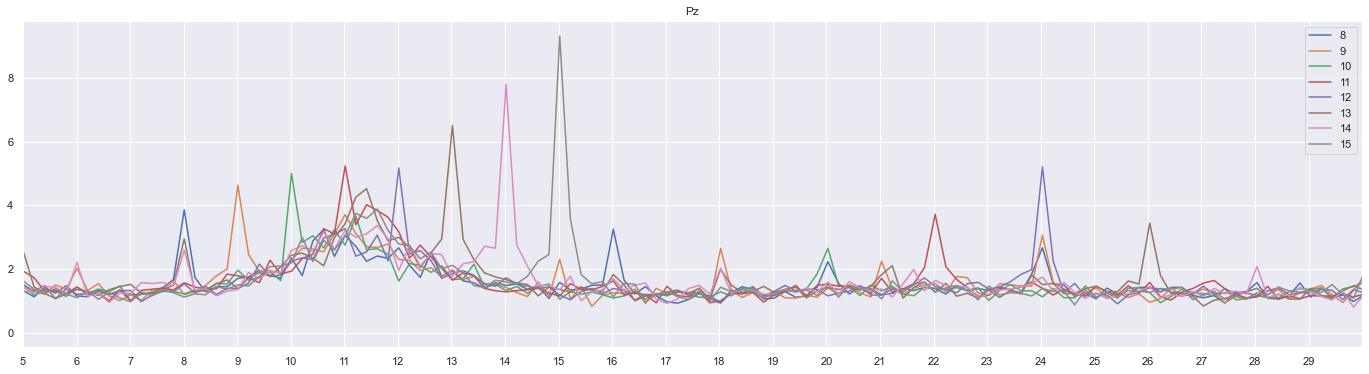

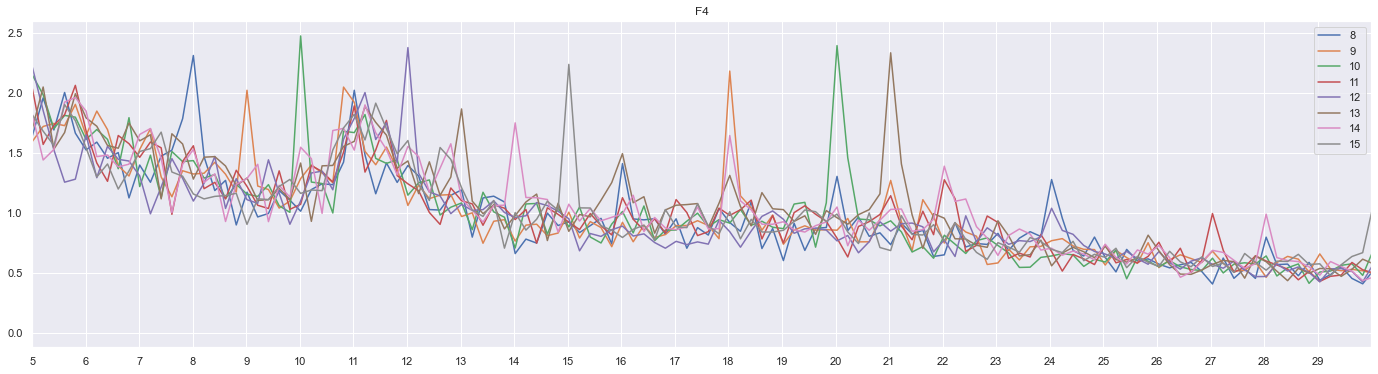

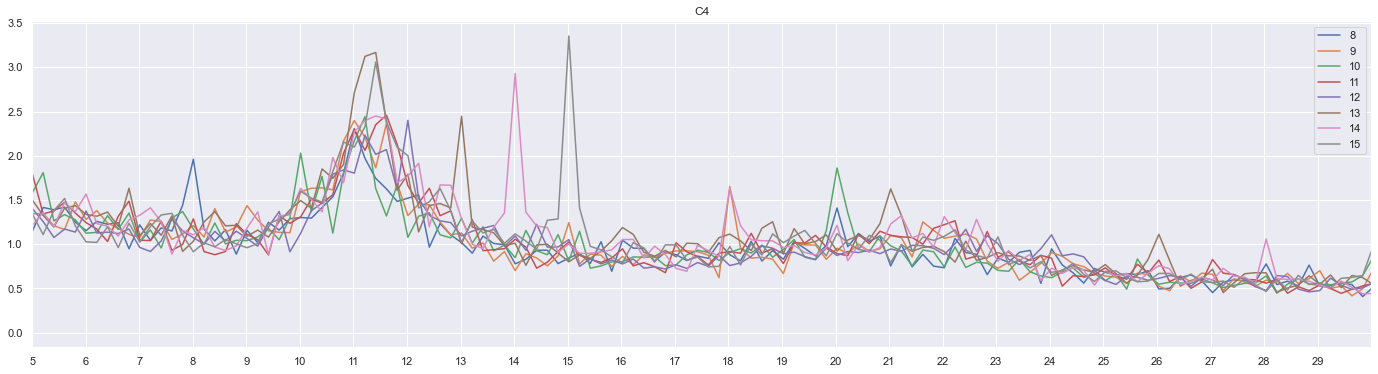

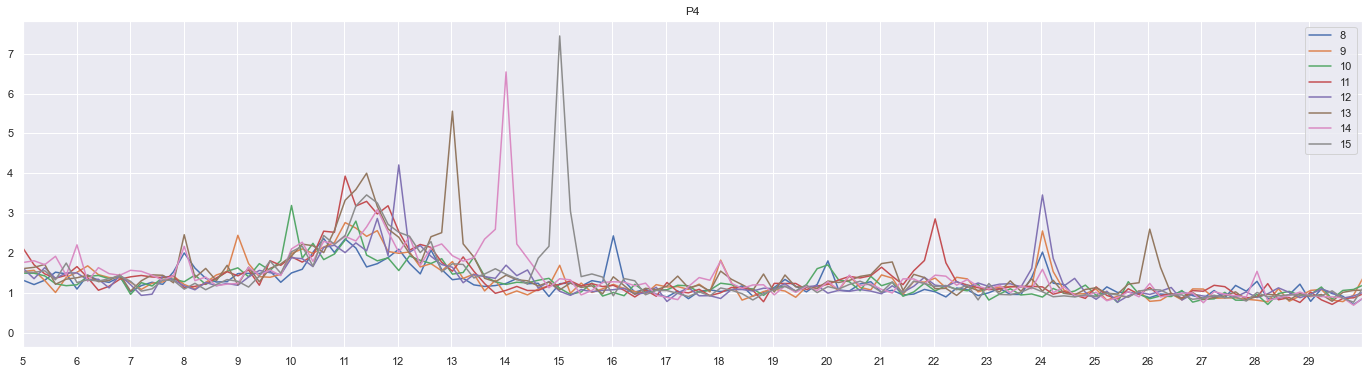

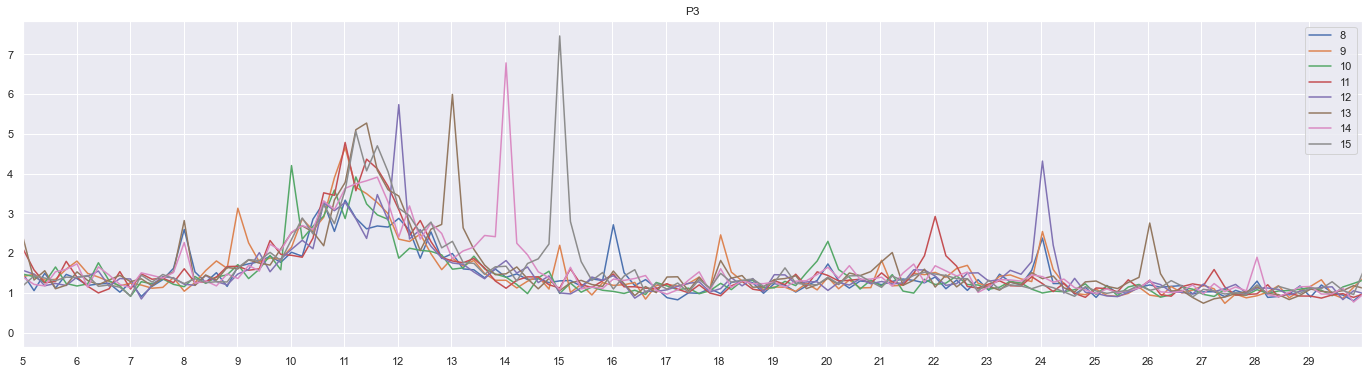

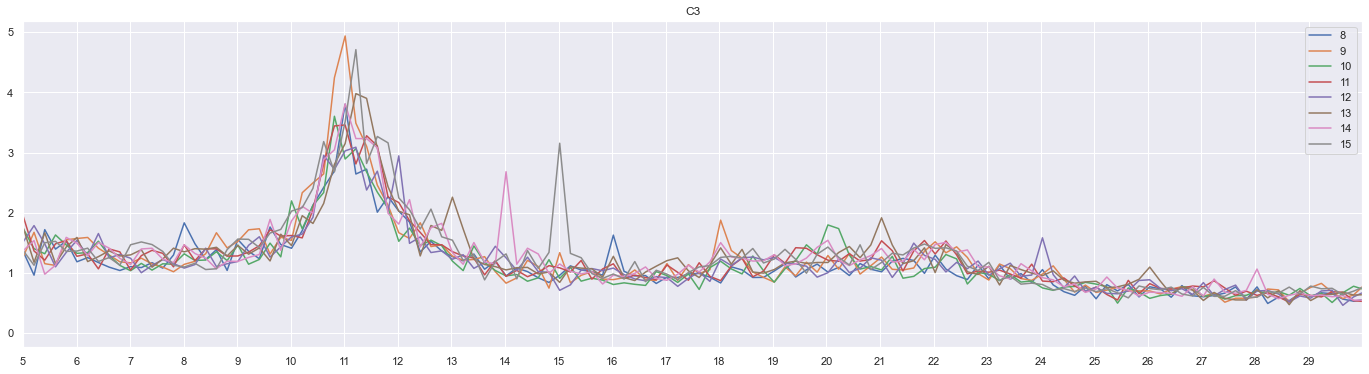

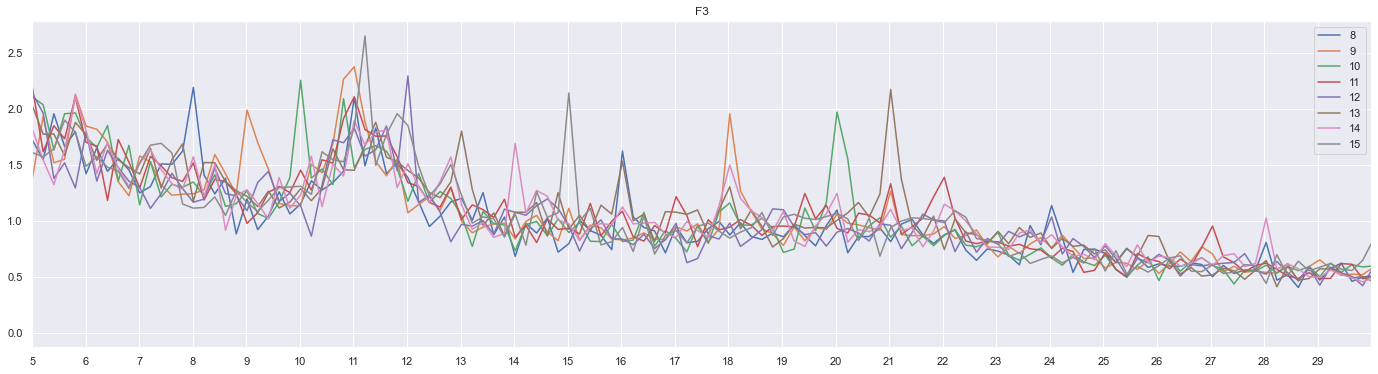

In [112]:
freqs = np.linspace(0.0, sampling_frequency / 2, timepoints_stimulus_duration // 2)
psd = 2/(timepoints_stimulus_duration / 2)*np.abs(fft(eeg_by_trial_zero)[:,:,:,:timepoints_stimulus_duration // 2])
psd = psd.mean(axis=0) # take the mean psd across sessions
# visualize some of the targets on frequency domain
# target_interest = [8.6, 9, 10.4, 12, 12.6, 13.2, 14.2, 14.6, 15, 15.4]
target_interest = [8, 9, 10, 11, 12, 13, 14, 15]
channel_interest = channels
for channel in channel_interest:
    plt.figure(figsize=(24, 6))
    ax = plt.subplot()
    ax.set_xlim(5, 30)
    for freq in target_interest:
        sns.lineplot(x=freqs, y=psd[list(freq_tab.keys()).index(freq), channels.index(channel),:], ax=ax, label=freq)
    plt.title(channel)
    plt.xticks(range(5,30));

In [110]:
def EEGNet(nb_classes, Chans = 64, Samples = 128, 
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    """ Keras Implementation of EEGNet
    http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta
    Note that this implements the newest version of EEGNet and NOT the earlier
    version (version v1 and v2 on arxiv). We strongly recommend using this
    architecture as it performs much better and has nicer properties than
    our earlier version. For example:
        
        1. Depthwise Convolutions to learn spatial filters within a 
        temporal convolution. The use of the depth_multiplier option maps 
        exactly to the number of spatial filters learned within a temporal
        filter. This matches the setup of algorithms like FBCSP which learn 
        spatial filters within each filter in a filter-bank. This also limits 
        the number of free parameters to fit when compared to a fully-connected
        convolution. 
        
        2. Separable Convolutions to learn how to optimally combine spatial
        filters across temporal bands. Separable Convolutions are Depthwise
        Convolutions followed by (1x1) Pointwise Convolutions. 
        
    
    While the original paper used Dropout, we found that SpatialDropout2D 
    sometimes produced slightly better results for classification of ERP 
    signals. However, SpatialDropout2D significantly reduced performance 
    on the Oscillatory dataset (SMR, BCI-IV Dataset 2A). We recommend using
    the default Dropout in most cases.
        
    Assumes the input signal is sampled at 128Hz. If you want to use this model
    for any other sampling rate you will need to modify the lengths of temporal
    kernels and average pooling size in blocks 1 and 2 as needed (double the 
    kernel lengths for double the sampling rate, etc). Note that we haven't 
    tested the model performance with this rule so this may not work well. 
    
    The model with default parameters gives the EEGNet-8,2 model as discussed
    in the paper. This model should do pretty well in general, although it is
	advised to do some model searching to get optimal performance on your
	particular dataset.
    We set F2 = F1 * D (number of input filters = number of output filters) for
    the SeparableConv2D layer. We haven't extensively tested other values of this
    parameter (say, F2 < F1 * D for compressed learning, and F2 > F1 * D for
    overcomplete). We believe the main parameters to focus on are F1 and D. 
    Inputs:
        
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.     
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D. 
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.
    """
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = tf.keras.layers.SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = tf.keras.layers.Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = tf.keras.Input(shape = (Chans, Samples, 1))

    ##################################################################
    block1       = tf.keras.layers.Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = tf.keras.layers.BatchNormalization()(block1)
    block1       = tf.keras.layers.DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = tf.keras.constraints.max_norm(1.))(block1)
    block1       = tf.keras.layers.BatchNormalization()(block1)
    block1       = tf.keras.layers.Activation('elu')(block1)
    block1       = tf.keras.layers.AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = tf.keras.layers.SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = tf.keras.layers.BatchNormalization()(block2)
    block2       = tf.keras.layers.Activation('elu')(block2)
    block2       = tf.keras.layers.AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = tf.keras.layers.Flatten(name = 'flatten')(block2)
    
    dense        = tf.keras.layers.Dense(nb_classes, name = 'dense', 
                         kernel_constraint = tf.keras.constraints.max_norm(norm_rate))(flatten)
    softmax      = tf.keras.layers.Activation('softmax', name = 'softmax')(dense)
    
    return tf.keras.Model(inputs=input1, outputs=softmax)

In [74]:
def EEGNet_SSVEP(nb_classes, Chans, Samples, 
             dropoutRate = 0.3, kernLength = 256, F1 = 96, 
             D = 1, F2 = 96, dropoutType = 'Dropout'):
    """ SSVEP Variant of EEGNet, as used in [1]. 
    Inputs:
        
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. 
      D               : number of spatial filters to learn within each temporal
                        convolution.
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.
      
      
    [1]. Waytowich, N. et. al. (2018). Compact Convolutional Neural Networks
    for Classification of Asynchronous Steady-State Visual Evoked Potentials.
    Journal of Neural Engineering vol. 15(6). 
    http://iopscience.iop.org/article/10.1088/1741-2552/aae5d8
    """
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = tf.keras.layers.SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = tf.keras.layers.Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = tf.keras.Input(shape = (Chans, Samples, 1))

    ##################################################################
    block1       = tf.keras.layers.Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = tf.keras.layers.BatchNormalization()(block1)
    block1       = tf.keras.layers.DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = tf.keras.constraints.max_norm(1.))(block1)
    block1       = tf.keras.layers.BatchNormalization()(block1)
    block1       = tf.keras.layers.Activation('elu')(block1)
    block1       = tf.keras.layers.AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = tf.keras.layers.SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = tf.keras.layers.BatchNormalization()(block2)
    block2       = tf.keras.layers.Activation('elu')(block2)
    block2       = tf.keras.layers.AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = tf.keras.layers.Flatten(name = 'flatten')(block2)
    
    dense        = tf.keras.layers.Dense(nb_classes, name = 'dense')(flatten)
    softmax      = tf.keras.layers.Activation('softmax', name = 'softmax')(dense)
    
    return tf.keras.Model(inputs=input1, outputs=softmax)

In [115]:
freq_tab, freq_by_trial.shape, eeg_by_trial.shape

({8.0: 0,
  8.2: 1,
  8.4: 2,
  8.6: 3,
  8.8: 4,
  9.0: 5,
  9.2: 6,
  9.4: 7,
  9.6: 8,
  9.8: 9,
  10.0: 10,
  10.2: 11,
  10.4: 12,
  10.6: 13,
  10.8: 14,
  11.0: 15,
  11.2: 16,
  11.4: 17,
  11.6: 18,
  11.8: 19,
  12.0: 20,
  12.2: 21,
  12.4: 22,
  12.6: 23,
  12.8: 24,
  13.0: 25,
  13.2: 26,
  13.4: 27,
  13.6: 28,
  13.8: 29,
  14.0: 30,
  14.2: 31,
  14.4: 32,
  14.6: 33,
  14.8: 34,
  15.0: 35,
  15.2: 36,
  15.4: 37,
  15.6: 38,
  15.8: 39},
 (20, 40),
 (20, 40, 7, 1500))

In [137]:
# shuffle the trials
perm_idx = np.random.permutation(len(freq_by_trial))
freq_by_trial = freq_by_trial[perm_idx]   # shape: (trials, num_targets)
eeg_by_trial_zero = eeg_by_trial_zero[perm_idx]  # shape: (trials, num_targets, channels, timepoints)

# subset the data
interest_freqs = [8, 9, 10, 11, 12, 13, 14, 15]
freq_to_label_func = np.vectorize(lambda freq: freq_tab[freq])
X = eeg_by_trial_zero[:, freq_to_label_func(interest_freqs), ...][..., np.newaxis]
y = freq_to_label_func(freq_by_trial[:, :len(interest_freqs)])  
assert np.max(y) == len(interest_freqs) - 1

# hyperparameters
epochs = 150
batch_size = 100
learning_rate = 1e-3
dropout_rate = 0.5

# build model
kf = KFold(n_splits=10)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index].reshape(-1, *X[train_index].shape[2:]), X[test_index].reshape(-1, *X[test_index].shape[2:])
    y_train, y_test = y[train_index].reshape(-1), y[test_index].reshape(-1)
    print(y_test[:5], y_train[:5])
    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)
    model = EEGNet_SSVEP(len(interest_freqs), num_channels, timepoints_stimulus_duration, dropoutRate=dropout_rate)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['acc'])
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)

[0 1 2 3 4] [0 1 2 3 4]
(180, 7, 1500, 1) (180,)
(20, 7, 1500, 1) (20,)
Epoch 1/150
2/2 [==============================] - 9s 4s/step - loss: 2.4203 - acc: 0.0889 - val_loss: 2.3015 - val_acc: 0.1500
Epoch 2/150
2/2 [==============================] - 8s 4s/step - loss: 2.1986 - acc: 0.2000 - val_loss: 2.3023 - val_acc: 0.0500
Epoch 3/150
2/2 [==============================] - 8s 4s/step - loss: 2.0042 - acc: 0.3056 - val_loss: 2.3027 - val_acc: 0.0500
Epoch 4/150
2/2 [==============================] - 8s 4s/step - loss: 1.8779 - acc: 0.3667 - val_loss: 2.3021 - val_acc: 0.1500
Epoch 5/150
1/2 [==============>...............] - ETA: 4s - loss: 1.7873 - acc: 0.4400

KeyboardInterrupt: 

## Channel-wise comparison

In [141]:
# subset the data
# interest_freqs = [8, 9, 10, 11, 12, 13, 14, 15]
interest_freqs = [8.6, 9, 10.4, 12, 12.6, 13.2, 14.2, 14.6, 15, 15.4]
freq_to_label_func = np.vectorize(lambda freq: freq_tab[freq])
y = freq_to_label_func(freq_by_trial[:, :len(interest_freqs)])  
assert np.max(y) == len(interest_freqs) - 1

# hyperparameters
epochs = 30
batch_size = 100
learning_rate = 1e-3
dropout_rate = 0.5

history = {}
# build model
for i in range(num_channels):
    kf = KFold(n_splits=10, random_state=2, shuffle=True)
    print(channels[i])
    for train_index, test_index in kf.split(X):
        print(test_index)
        X = eeg_by_trial_zero[:, freq_to_label_func(interest_freqs), i, :][..., np.newaxis]
        X_train, X_test = X[train_index].reshape(-1, *X[train_index].shape[2:])[:, np.newaxis, ...], X[test_index].reshape(-1, *X[test_index].shape[2:])[:, np.newaxis, ...]
        y_train, y_test = y[train_index].reshape(-1), y[test_index].reshape(-1)
        model = EEGNet_SSVEP(len(interest_freqs), 1, timepoints_stimulus_duration, dropoutRate=dropout_rate)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['acc'])
        model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)
        break

Pz
[ 4 12]
Epoch 1/30
2/2 [==============================] - 3s 1s/step - loss: 2.4120 - acc: 0.0889 - val_loss: 2.3020 - val_acc: 0.1000
Epoch 2/30
2/2 [==============================] - 2s 727ms/step - loss: 2.1977 - acc: 0.1778 - val_loss: 2.3011 - val_acc: 0.1500
Epoch 3/30
2/2 [==============================] - 2s 732ms/step - loss: 2.0347 - acc: 0.2556 - val_loss: 2.2993 - val_acc: 0.1500
Epoch 4/30
2/2 [==============================] - 2s 699ms/step - loss: 1.9520 - acc: 0.3667 - val_loss: 2.2971 - val_acc: 0.2000
Epoch 5/30
2/2 [==============================] - 2s 703ms/step - loss: 1.7664 - acc: 0.4222 - val_loss: 2.2943 - val_acc: 0.1000
Epoch 6/30
2/2 [==============================] - 2s 720ms/step - loss: 1.6728 - acc: 0.5222 - val_loss: 2.2905 - val_acc: 0.1500
Epoch 7/30
2/2 [==============================] - 1s 683ms/step - loss: 1.4603 - acc: 0.7000 - val_loss: 2.2857 - val_acc: 0.2000
Epoch 8/30
2/2 [==============================] - 1s 740ms/step - loss: 1.3434 - a